# Build a biGRU neural network model

In this notebook, we are going to build a bidirectional Gated Recurrent Unit neural network model, in which we will implement and use the following architectures and tools:
- Bidirectional GRU
- Multi-layer (stacked) GRU
- Dropout
- Spatial Dropout after embedding layer
- Max-pooling
- Average-pooling
- pack_padded_sequence

The model is going to be trained on the clean_review column from the training dataset, other features will be used in the next notebook. In the end, the model will be evaluated on the test set to determine the generalization error.

We will perform the hyperparameter fine-tuning and visualize model's learning curves to compare the model's performance while working on different set of parameters. 

#### Gated Recurrent Unit
Gated Recurrent Unit is the simpler variation of the LSTM (Long-Short Term Memory). Both these architectures were proposed as the remedy for the RNN's vanishing gradient problems. GRU comprised of only two gates, while its ancestor - LSTM had 3 gates in its unit, thus the GRU unit that was firstly introduced by the Kyunghyun Cho in the following paper:
https://arxiv.org/pdf/1406.1078v3.pdf, is much simpler to compute and implement.
<br><br>
The GRU consists of two gates:
- Update  gate *z* that selects whether  the  hidden  state  is  to  be  updated  with a  new  hidden  state ̃*h*.
- Reset  gate *r* that decides whether the previous hidden state is ignored.

<div>
<img src="assets/GRU_shema.png" width="400" />
</div>

<p style='text-align: center;'>GRU shema [By Jeblad - Own work, CC BY-SA 4.0, https://commons.wikimedia.org/w/index.php?curid=66225938]</p>

For each element in the input sequence, each layer computes the following function:<br><br>
$ r_t = sigma(W_{ir} x_t + b_{ir} + W_{hr} h_{(t-1)} + b_{hr})$<br>
$ z_t = sigma(W_{iz} x_t + b_{iz} + W_{hz} h_{(t-1)} + b_{hz})$<br>
$ `h_t = tanh(W_{in} x_t + b_{in} + r_t * (W_{hn} h_{(t-1)}+ b_{hn}))$<br>
$ h_t = (1 - z_t) * `h_t + z_t * h_{(t-1)}$
<br>

#### Bidirectional RNN
Bidirectional Recurrent Neural Network consists of two recurrent hidden layers, that have opposite direction, in other words, one layer reads the sequence from the beginning to the end, while the other one reads it in reverse order. This architecture provides the model with much more information, as it includes both past and future context.<br>
<div>
<img src="assets/RNN-bidirectional.png" width="400" />
</div>

<p style='text-align: center;'>Bidirectional RNN schema [http://colah.github.io/posts/2015-09-NN-Types-FP/]</p>
<br>
Another concept that is worth to mention is the <b>stacked RNN</b> that simply consists of two or more hidden layers stacked together.

<br>

#### Spatial dropout

Spatial dropout is another method of using dropout regularization that is applied most commonly in Convolutional Neural Networks. In contrast to the traditional dropout, the spatial dropout zeroes out the entire 1D feature map from the embedding feature vector of each word. 

#### Model's architecture

The graph of the model created using tensorboardX is depicted below.<br>

<div>
<img src="assets/BiGRU_model_graph.png" width="700"/>
</div>

A lot is going on the above plot, so for the sake of simplicity, I have created an additional schema that shows the layout of the model.
<br>
<br>
<div>
<img src="assets/BiGRU_schema.png" width="750" />
</div>

After the GRU layer we will concatenate both, the average pooling and max pooling of the hidden representation and the last hidden state of GRU in order to prevent our model from forgetting infromations. This architecture is described in the following paper: https://arxiv.org/pdf/1801.06146.pdf. There is also the possibility to get rid of the last hidden state from our model at all, this kind of architecture, that uses max-pooling or avg-pooling is depicted in the paper: https://arxiv.org/pdf/1705.02364.pdf.

### Building and training the model

Let's start with importing all indispensable libraries.

In [2]:
from batch_iterator import BatchIterator
from early_stopping import EarlyStopping
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import device
from tqdm import tqdm_notebook
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tensorboardX import SummaryWriter

Now, we are going to load the tarining and validation sets, but we will use only the clean_review column and label column.

In [15]:
# Import the dataset. Use clean_review and label columns
train_dataset = pd.read_csv('dataset/drugreview_feat_clean/train_feat_clean.csv', 
                            usecols=['clean_review', 'rating'])

# Change columns order
train_dataset['label'] = train_dataset.rating >= 5
train_dataset = train_dataset[['clean_review', 'label']]

In [16]:
# Depict the first 5 rows of the training set
train_dataset = train_dataset.dropna()
train_dataset.head()

,clean_review,label
2,young suffering severe extreme neck pain resul...,True
5,found work helping good nights sleep don&#039;...,True
9,given medication gastroenterologist office wor...,False
12,recently laparoscopic hysterectomy know anesth...,True
13,mirena year experienced effects effects watch ...,False


In [17]:
# Import the dataset. Use clean_review and label columns
val_dataset = pd.read_csv('dataset/drugreview_feat_clean/val_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order

val_dataset['label'] = val_dataset.rating >= 5
val_dataset = val_dataset[['clean_review', 'label']]

In [18]:
# Depict the first 5 rows of the validation set
val_dataset = val_dataset.dropna()
val_dataset.head()

,clean_review,label
0,year old son took night went deep sea fishing ...,True
1,daughter epiduo grade junior year work wonders...,True
2,i&#039;ve implant months day got totally felt ...,True
3,wanted wait days post couldn&#039;t results am...,True
4,colonoscopy best prep far morning took prep pm...,True


Below we will use the BatchIterator class defined in the previous notebook to create the vocabulary, trim sequences in terms of the rare word occurrence and the length, map words to their numerical representation (word2index), furthermore BatchIterator sorts dataset examples, generates batches, performs sequence padding and enables to use it instance to iterate through all batches.

In [19]:
train_iterator = BatchIterator(train_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                               word2index=None, sos_token='<SOS>', eos_token='<EOS>', unk_token='<UNK>',
                               pad_token='<PAD>', min_word_count=3, max_vocab_size=None, max_seq_len=0.9,
                               use_pretrained_vectors=False, glove_path='glove/', glove_name='glove.6B.100d.txt',
                               weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
8674/21861 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 58
Mapped words to indices
Batches created


In [20]:
val_iterator = BatchIterator(val_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                             word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                             unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                             max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                             glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
4655/11853 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 57
Mapped words to indices
Batches created


We have to check out how batches that we created look like before we pass them into the model. For the record, the set of batches for input and output variables is returned as a dictionary, thus we will just look at the dictionary keys to find out how to extract particular variables.

In [21]:
for batches in train_iterator:
    print(batches.keys())
    break

dict_keys(['input_seq', 'target', 'x_lengths'])


Notice that the output batch has the dimensions: (batch_size, seq_len)

In [22]:
for batches in train_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([256, 6])
target shape:  torch.Size([256])
x_lengths shape:  torch.Size([256])


In [23]:
for batches in val_iterator:
    # Unpack the dictionary of batches
    input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
    print('input_seq shape: ', input_seq.size())
    print('target shape: ', target.size())
    print('x_lengths shape: ', x_lengths.size())
    break

input_seq shape:  torch.Size([256, 31])
target shape:  torch.Size([256])
x_lengths shape:  torch.Size([256])


Next step is to build the biGRU model.

In [24]:
class BiGRU(nn.Module):
    """BiDirectional GRU neural network model.
        
    Parameters
    ----------
    hidden_size: int
        Number of features in the hidden state.
    vocab_size: int
        The size of the vocabulary.
    embedding_dim: int
        The size of each embedding vector.
    output_size: int
        Number of classes.
    n_layers: int, optional (default=1)
        Number of stacked recurrent layers.
    dropout: float, optional (default=0.2)
        Probability of an element of the tensor to be zeroed.
    spatial_dropout: boolean, optional (default=True)
        Whether to use the spatial dropout.
    bidirectional: boolean, optional (default=True)
        Whether to use the bidirectional GRU.

    """
    
    def __init__(self, hidden_size, vocab_size, embedding_dim, output_size, n_layers=1, dropout=0.2,
                 spatial_dropout=True, bidirectional=True):
        
        # Inherit everything from the nn.Module
        super(BiGRU, self).__init__()
        
        # Initialize attributes
        self.hidden_size = hidden_size
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.output_size = output_size
        self.n_layers = n_layers
        self.dropout_p = dropout
        self.spatial_dropout = spatial_dropout
        self.bidirectional = bidirectional
        self.n_directions = 2 if self.bidirectional else 1
        
        # Initialize layers
        self.embedding = nn.Embedding(self.vocab_size, self.embedding_dim)
        self.dropout = nn.Dropout(self.dropout_p)
        if self.spatial_dropout:
            self.spatial_dropout1d = nn.Dropout2d(self.dropout_p)
        self.gru = nn.GRU(self.embedding_dim, self.hidden_size, num_layers=self.n_layers, 
                          dropout=(0 if n_layers == 1 else self.dropout_p), batch_first=True,
                          bidirectional=self.bidirectional)
        # Linear layer input size is equal to hidden_size * 3, becuase
        # we will concatenate max_pooling ,avg_pooling and last hidden state
        self.linear = nn.Linear(self.hidden_size * 3, self.output_size)

        
    def forward(self, input_seq, input_lengths, hidden=None):
        """Forward propagate through the neural network model.
        
        Parameters
        ----------
        input_seq: torch.Tensor
            Batch of input sequences.
        input_lengths: torch.LongTensor
            Batch containing sequences lengths.
        hidden: torch.FloatTensor, optional (default=None)
            Tensor containing initial hidden state.
            
        Returns
        -------
        torch.Tensor
            Logarithm of softmaxed input tensor.
        
        """
        # Extract batch_size
        self.batch_size = input_seq.size(0)
        
        # Embeddings shapes
        # Input: (batch_size,  seq_length)
        # Output: (batch_size, seq_length, embedding_dim)
        emb_out = self.embedding(input_seq)
        
        if self.spatial_dropout:
            # Convert to (batch_size, embedding_dim, seq_length)
            emb_out = emb_out.permute(0, 2, 1)
            emb_out = self.spatial_dropout1d(emb_out)
            # Convert back to (batch_size, seq_length, embedding_dim)
            emb_out = emb_out.permute(0, 2, 1)
        else:
            emb_out = self.dropout(emb_out)
        
        # Pack padded batch of sequences for RNN module
        packed_emb = nn.utils.rnn.pack_padded_sequence(emb_out, input_lengths, batch_first=True)
                
        # GRU input/output shapes, if batch_first=True
        # Input: (batch_size, seq_len, embedding_dim)
        # Output: (batch_size, seq_len, hidden_size*num_directions)
        # Number of directions = 2 when used bidirectional, otherwise 1
        # shape of hidden: (n_layers x num_directions, batch_size, hidden_size)
        # Hidden state defaults to zero if not provided
        gru_out, hidden = self.gru(packed_emb, hidden)
        # gru_out: tensor containing the output features h_t from the last layer of the GRU
        # gru_out comprises all the hidden states in the last layer ("last" depth-wise, not time-wise)
        # For biGRu gru_out is the concatenation of a forward GRU representation and a backward GRU representation
        # hidden (h_n) comprises the hidden states after the last timestep
        
        # Extract and sum last hidden state
        # Input hidden shape: (n_layers x num_directions, batch_size, hidden_size)
        # Separate hidden state layers
        hidden = hidden.view(self.n_layers, self.n_directions, self.batch_size, self.hidden_size)
        last_hidden = hidden[-1]
        # last hidden shape (num_directions, batch_size, hidden_size)
        # Sum the last hidden state of forward and backward layer
        last_hidden = torch.sum(last_hidden, dim=0)
        # Summed last hidden shape (batch_size, hidden_size)
        
        # Pad a packed batch
        # gru_out output shape: (batch_size, seq_len, hidden_size*num_directions)
        gru_out, lengths = nn.utils.rnn.pad_packed_sequence(gru_out, batch_first=True)
              
        # Sum the gru_out along the num_directions
        if self.bidirectional:
            gru_out = gru_out[:,:,:self.hidden_size] + gru_out[:,:,self.hidden_size:]
        
        # Select the maximum value over each dimension of the hidden representation (max pooling)
        # Permute the input tensor to dimensions: (batch_size, hidden, seq_len)
        # Output dimensions: (batch_size, hidden_size)
        max_pool = F.adaptive_max_pool1d(gru_out.permute(0,2,1), (1,)).view(self.batch_size,-1)
        
        # Consider the average of the representations (mean pooling)
        # Sum along the batch axis and divide by the corresponding lengths (FloatTensor)
        # Output shape: (batch_size, hidden_size)
        avg_pool = torch.sum(gru_out, dim=1) / lengths.view(-1,1).type(torch.FloatTensor) 

        # Concatenate max_pooling, avg_pooling and last hidden state tensors
        concat_out = torch.cat([last_hidden, max_pool, avg_pool], dim=1)

        #concat_out = self.dropout(concat_out)
        out = self.linear(concat_out)
        return F.log_softmax(out, dim=-1)
    
    
    def add_loss_fn(self, loss_fn):
        """Add loss function to the model.
        
        """
        self.loss_fn = loss_fn
        

    def add_optimizer(self, optimizer):
        """Add optimizer to the model.
        
        """
        self.optimizer = optimizer
        
        
    def add_device(self, device=torch.device('cpu')):
        """Specify the device.
        
        """
        self.device = device
    
    
    def train_model(self, train_iterator):
        """Perform single training epoch.
        
        Parameters
        ----------
        train_iterator: BatchIterator
            BatchIterator class object containing training batches.
            
        Returns
        -------
        train_losses: list
            List of the training average batch losses.
        avg_loss: float
            Average loss on the entire training set.
        accuracy: float
            Models accuracy on the entire training set.
            
        """
        self.train()
        
        train_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
            
        for i, batches in tqdm_notebook(enumerate(train_iterator, 1), total=len(train_iterator), desc='Training'):
            input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
            
            input_seq.to(self.device)
            target.to(self.device)
            x_lengths.to(self.device)
            
            self.optimizer.zero_grad()

            pred = self.forward(input_seq, x_lengths)
            loss = self.loss_fn(pred, target)
            loss.backward()
            losses.append(loss.data.cpu().numpy())
            self.optimizer.step()
            
            losses_list.append(loss.data.cpu().numpy())
            
            pred = torch.argmax(pred, 1)

            if self.device.type == 'cpu':
                batch_correct += (pred.cpu() == target.cpu()).sum().item()

            else:
                batch_correct += (pred == target).sum().item()

            num_seq += len(input_seq)     
    
            if i % 100 == 0:
                avg_train_loss = np.mean(losses)
                train_losses.append(avg_train_loss)
                
                accuracy = batch_correct / num_seq
                
                print('Iteration: {}. Average training loss: {:.4f}. Accuracy: {:.3f}'\
                      .format(i, avg_train_loss, accuracy))
                
                losses = []
                
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
                              
        return train_losses, avg_loss, accuracy
    
    
    def evaluate_model(self, eval_iterator, conf_mtx=False):
        """Perform the one evaluation epoch.
        
        Parameters
        ----------
        eval_iterator: BatchIterator
            BatchIterator class object containing evaluation batches.
        conf_mtx: boolean, optional (default=False)
            Whether to print the confusion matrix at each epoch.
            
        Returns
        -------
        eval_losses: list
            List of the evaluation average batch losses.
        avg_loss: float
            Average loss on the entire evaluation set.
        accuracy: float
            Models accuracy on the entire evaluation set.
        conf_matrix: list
            Confusion matrix.
            
        """
        self.eval()
        
        eval_losses = []
        losses = []
        losses_list = []
        num_seq = 0
        batch_correct = 0
        pred_total = torch.LongTensor()
        target_total = torch.LongTensor()
        
        with torch.no_grad():
            for i, batches in tqdm_notebook(enumerate(eval_iterator, 1), total=len(eval_iterator), desc='Evaluation'):
                input_seq, target, x_lengths = batches['input_seq'], batches['target'], batches['x_lengths']
                
                input_seq.to(self.device)
                target.to(self.device)
                x_lengths.to(self.device)

                pred = self.forward(input_seq, x_lengths)
                loss = self.loss_fn(pred, target)
                losses.append(loss.data.cpu().numpy())
                losses_list.append(loss.data.cpu().numpy())
                
                pred = torch.argmax(pred, 1)
                                
                if self.device.type == 'cpu':
                    batch_correct += (pred.cpu() == target.cpu()).sum().item()
                    
                else:
                    batch_correct += (pred == target).sum().item()
                    
                num_seq += len(input_seq)     
                
                pred_total = torch.cat([pred_total, pred], dim=0)
                target_total = torch.cat([target_total, target], dim=0)
                
                if i % 100 == 0:
                    avg_batch_eval_loss = np.mean(losses)
                    eval_losses.append(avg_batch_eval_loss)
                    
                    accuracy = batch_correct / num_seq
                    
                    print('Iteration: {}. Average evaluation loss: {:.4f}. Accuracy: {:.2f}'\
                          .format(i, avg_batch_eval_loss, accuracy))

                    losses = []
                    
            avg_loss_list = []
                    
            avg_loss = np.mean(losses_list)
            accuracy = batch_correct / num_seq
            
            conf_matrix = confusion_matrix(target_total.view(-1), pred_total.view(-1))
        
        if conf_mtx:
            print('\tConfusion matrix: ', conf_matrix)
            
        return eval_losses, avg_loss, accuracy, conf_matrix


Now we will instantiate the model, add loss function, optimizer, and device to it and begin the training.

In [25]:
# Initialize parameters
hidden_size = 8
vocab_size = len(train_iterator.word2index)
embedding_dim = 200
output_size = 2
n_layers = 1
dropout = 0.5
learning_rate = 0.001
epochs = 20
spatial_dropout = True

# Check whether system supports CUDA
CUDA = torch.cuda.is_available()

model = BiGRU(hidden_size, vocab_size, embedding_dim, output_size, n_layers, dropout,
              spatial_dropout, bidirectional=True)

# Move the model to GPU if possible
if CUDA:
    model.cuda()

model.add_loss_fn(nn.NLLLoss())

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
model.add_optimizer(optimizer)

device = torch.device('cuda' if CUDA else 'cpu')

model.add_device(device)

# Instantiate the EarlyStopping
early_stop = EarlyStopping(wait_epochs=1)

train_losses_list, train_avg_loss_list, train_accuracy_list = [], [], []
eval_avg_loss_list, eval_accuracy_list, conf_matrix_list = [], [], []

for epoch in range(epochs):
    
    print('\nStart epoch [{}/{}]'.format(epoch+1, epochs))
    
    train_losses, train_avg_loss, train_accuracy = model.train_model(train_iterator)
    
    train_losses_list.append(train_losses)
    train_avg_loss_list.append(train_avg_loss)
    train_accuracy_list.append(train_accuracy)
    
    _, eval_avg_loss, eval_accuracy, conf_matrix = model.evaluate_model(val_iterator)
    
    eval_avg_loss_list.append(eval_avg_loss)
    eval_accuracy_list.append(eval_accuracy)
    conf_matrix_list.append(conf_matrix)
    
    print('\nEpoch [{}/{}]: Train accuracy: {:.3f}. Train loss: {:.4f}. Evaluation accuracy: {:.3f}. Evaluation loss: {:.4f}'\
          .format(epoch+1, epochs, train_accuracy, train_avg_loss, eval_accuracy, eval_avg_loss))
    
    if early_stop.stop(eval_avg_loss, model, delta=0.003):
        break

    


Start epoch [1/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [1/20]: Train accuracy: 0.677. Train loss: 0.6172. Evaluation accuracy: 0.757. Evaluation loss: 0.5549

Start epoch [2/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [2/20]: Train accuracy: 0.747. Train loss: 0.5652. Evaluation accuracy: 0.757. Evaluation loss: 0.5431

Start epoch [3/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [3/20]: Train accuracy: 0.747. Train loss: 0.5577. Evaluation accuracy: 0.757. Evaluation loss: 0.5304

Start epoch [4/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [4/20]: Train accuracy: 0.747. Train loss: 0.5496. Evaluation accuracy: 0.759. Evaluation loss: 0.5149

Start epoch [5/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [5/20]: Train accuracy: 0.748. Train loss: 0.5375. Evaluation accuracy: 0.761. Evaluation loss: 0.4975

Start epoch [6/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [6/20]: Train accuracy: 0.752. Train loss: 0.5246. Evaluation accuracy: 0.770. Evaluation loss: 0.4812

Start epoch [7/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [7/20]: Train accuracy: 0.758. Train loss: 0.5114. Evaluation accuracy: 0.776. Evaluation loss: 0.4685

Start epoch [8/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [8/20]: Train accuracy: 0.768. Train loss: 0.4945. Evaluation accuracy: 0.785. Evaluation loss: 0.4586

Start epoch [9/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [9/20]: Train accuracy: 0.774. Train loss: 0.4810. Evaluation accuracy: 0.795. Evaluation loss: 0.4504

Start epoch [10/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [10/20]: Train accuracy: 0.785. Train loss: 0.4657. Evaluation accuracy: 0.800. Evaluation loss: 0.4441

Start epoch [11/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [11/20]: Train accuracy: 0.786. Train loss: 0.4577. Evaluation accuracy: 0.805. Evaluation loss: 0.4397

Start epoch [12/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [12/20]: Train accuracy: 0.794. Train loss: 0.4457. Evaluation accuracy: 0.809. Evaluation loss: 0.4347

Start epoch [13/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [13/20]: Train accuracy: 0.803. Train loss: 0.4345. Evaluation accuracy: 0.814. Evaluation loss: 0.4323

Start epoch [14/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [14/20]: Train accuracy: 0.808. Train loss: 0.4252. Evaluation accuracy: 0.815. Evaluation loss: 0.4310

Start epoch [15/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [15/20]: Train accuracy: 0.813. Train loss: 0.4141. Evaluation accuracy: 0.813. Evaluation loss: 0.4300

Start epoch [16/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [16/20]: Train accuracy: 0.816. Train loss: 0.4094. Evaluation accuracy: 0.816. Evaluation loss: 0.4283

Start epoch [17/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [17/20]: Train accuracy: 0.822. Train loss: 0.3956. Evaluation accuracy: 0.816. Evaluation loss: 0.4289

Start epoch [18/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [18/20]: Train accuracy: 0.824. Train loss: 0.3966. Evaluation accuracy: 0.815. Evaluation loss: 0.4284

Start epoch [19/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [19/20]: Train accuracy: 0.830. Train loss: 0.3844. Evaluation accuracy: 0.816. Evaluation loss: 0.4285

Start epoch [20/20]


Training:   0%|          | 0/57 [00:00<?, ?it/s]

Evaluation:   0%|          | 0/17 [00:00<?, ?it/s]


Epoch [20/20]: Train accuracy: 0.831. Train loss: 0.3841. Evaluation accuracy: 0.815. Evaluation loss: 0.4274


In [26]:
# Add the dataset initial loss
train_avg_loss_list.insert(0, train_losses_list[0][0])
eval_avg_loss_list.insert(0, train_losses_list[0][0])

IndexError: list index out of range

In [ ]:
# Plot the training and the validation learning curve
plt.figure(figsize=(8,5))
plt.plot(train_avg_loss_list, label='Training loss')
plt.plot(eval_avg_loss_list, label='Evaluation loss')
plt.xlabel('Epoch', size=12)
plt.ylabel('Loss', size=12)
plt.title('biGRU model learning curves')
plt.xticks(ticks=range(21))
plt.legend()
plt.show()

In [ ]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The model achieved the validation accuracy of 0.878, while the training accuracy was 0.908. The model's best state was saved to the *checkpoint.pt* file in the current directory. The training wasn't stopped by EarlyStopping object because the validation loss changes were too small and fluctuated near the same value.

The training process that is presented above regards the model with the tuned hyperparameters. The steps we went through when doing hyperparameters fine-tuning are listed in the next section.

### Hyperparameters fine-tuning

After the model is created we have to tune its hyperparameters like hidden_size, embedding_dim, n_layers, dropout, spatial_dropout, learning_rate, batch_size, seq_length or min_word_count and then chose the set of parameters that enable the model to achieve the best performance (a model that returns the highest accuracy or lowest loss) on the validation set.

Below we will show how the training and validation losses change during the training, do to so we have to disable the early stopping. We are interested in comparing training and validations losses in terms of their values but also in the directions in which they are heading during the training. This will help us discern the overfitting if it occurs.

The initial parameters used in our model are the following:
- hidden_size = 100
- embedding_dim = 200
- n_layers = 1
- dropout = 0.2
- learning_rate = 0.001
- batch_size = 32
- spatial_dropout = False
- min_word_count = 5
- max_seq_len = 0.8

Then we will change one of the above hyperparameters, train the model and depict the training and validation loss at each epoch during the training.

#### 1. Learning curves for the model with dropout  set to 0.2.

dropout = 0.2

<div>
<img src="assets/learning_curves_droput02.png" width="500" />
</div>

With the lowest evaluation loss (at second epoch), the model archived evaluation accuracy of 0.861 while the training accuracy at that time was 0.883.

We can notice on the preceding plot, that the training loss constantly decrease together with the validation loss, but at the second epoch, the validation loss reverse and begin to increase. This behaviour indicates that our model is overfitted, it learns too well how to map training input variables to the target, thus it cannot generalize its performance on some unseen data (validation set). One of the solutions to this problem is to increase the dropout probability, so the neural network will be forced to learn some more robust correlations in the data since the neurons will not depend anymore on each other, therefore the overfitting will be reduced.  The best remedy to the overfitting issue would be to gain more training examples, but our data set is finite, so we are not able to do that..

#### 2. Learning curves for the model with dropout set to 0.5.

dropout = 0.5

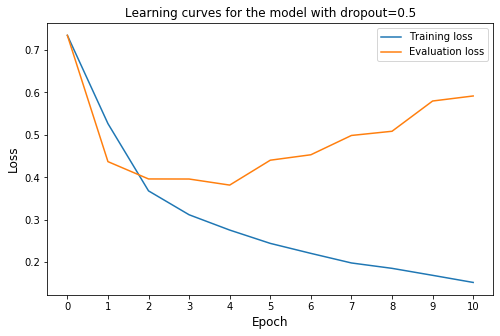

With dropout probability set to 0.5 the validation loss decrease longer than in the first case and reverses at 5th epoch (at the value of loss a bit greater than with dropout = 0.2). This denotes that the overfitting problem still occurs in our model. The validation accuracy is comparable to the previous model.

In the next training procedure, we will use the spatial dropout instead of the traditional dropout after the embedding layer.

#### 3. Learning curves for the model with spatial dropout set to 0.5.

dropout = 0.5 <br>
spatial_dropout = True

<div>
<img src="assets/learning_curves_spatial_droput.png" width="500" />
</div>

When we use the spatial dropout instead of normal dropout the evaluation loss decrease to the value around 0.36, similar to the first example where we used dropout = 0.2, but lower than with the dropout probability set to 0.5. With spatial dropout, the loss begin to reverse at the second epoch, but it increases much slower than in the previous cases (the gap between training loss and validation loss is smaller). As a summary, we can say that considering all regularization methods results, the spatial dropout provides the model best behaviour.

The next hyperparameter that we are going to tune is the hidden_size.

#### 4. Learning curves for the model with hidden_size = 64.

There are many rules regarding the choice of the hidden size. For instance, we can use the following formula to calculate the number of hidden units $N_{h}$ [https://ai.stackexchange.com/questions/3156/how-to-select-number-of-hidden-layers-and-number-of-memory-cells-in-an-lstm]:
<br>

<p><center>$N_{h} = \frac{N_{s}}{(\alpha \cdot (N_{i} + N_{0}))}$</center></p>

Where: <br>
$N_{s}$ - number of samples in training data set. <br>
$\alpha$ - an arbitrary scaling factor usually 2-10.<br>
$N_{i}$ - number of input neurons.<br>
$N_{0}$ - number of output neurons.<br>

Nevertheless in most cases, the number of hidden units have to be figured out by series of trials.

dropout = 0.5 <br>
spatial_dropout = True <br>
hidden_size = 64 <br>

<div>
<img src="assets/learning_curves_hidden64.png" width="500" />
</div>

As we can see reducing the number of hidden units makes the validation loss curve more flat after the first epoch than it was in the preceding examples.

We will go further and decrease the hidden_size to 32.

#### 5. Learning curves for the model with hidden_size = 32.

dropout = 0.5 <br>
spatial_dropout = True <br>
hidden_size = 32 <br>

<div>
<img src="assets/learning_curves_hidden32.png" width="500" />
</div>

After decreasing the hidden_size to 32, the validation loss became even more flat and at the 3rd epoch, it begins to fluctuate around the value of 0.38. We can see that decreasing the number of hidden units helped and learning curves starting to look as expected, so we will diminish the hidden_size one more time.

#### 6. Learning curves for the model with hidden_size = 16.

dropout = 0.5 <br>
spatial_dropout = True <br>
hidden_size = 16 <br>

<div>
<img src="assets/learning_curves_hidden16.png" width="500" />
</div>

This time the validation learning curve takes a bit lower values and it is more smooth than the previous one.

#### 7. Learning curves for the model with hidden_size = 8.

dropout = 0.5 <br>
spatial_dropout = True <br>
hidden_size = 8 <br>

<div>
<img src="assets/learning_curves_hidden8.png" width="500" />
</div>

The validation loss slowly, but constantly decreases during the training, so we can say that overfitting has been overcame.

#### 8. Learning curves for the model with n_layers = 2.

dropout = 0.5 <br>
spatial_dropout = True <br>
hidden_size = 8 <br>
n_layers = 2 <br>

<div>
<img src="assets/learning_curves_nlayers2.png" width="500" />
</div>

Using one addtional GRU layer didn't make a difference for our model's performance.

#### 9. Learning curves for the model with batch_size = 16.

Now we are going to change the batch_size to 16, as reducing batch size might work as regularizer since losses calculated on small batches are noisier, thus model has a lower tendentious to overfitting. The drawback of this method is the processing time, which increases while batch size decreases. Notice that we will change back the n_layers to 1.

dropout = 0.5 <br>
spatial_dropout = True <br>
hidden_size = 8 <br>
n_layers = 1 <br>
batch_size = 16 <br>

<div>
<img src="assets/learning_curves_batch16.png" width="500" />
</div>

Reducing the batch_size cause that the validation loss diminished to the value around 0.33 (among to the lowest of all our trials), but then the loss began to increase. That might be only some local peak, or the model started to overfit to the training dataset.

The validation loss curve tends to be under the training curve for most of the time. The explanation of why it behaves like that is the following:
- The validation error is smaller than the training error because the dropout is active during the training, while during the evaluation, dropout layer is inactive, thus we got more smooth results in the second case.  
- The training loss is measured as the mean loss on the entire training set, and since the performance improves during the training, the general training loss depicted on the plot is worse than the lowest loss calculated at the end of the set. While the validation loss is calculated using the model's last state, which is associated with the best performance at the given time.

#### 10. Learning curves for the model with batch_size = 64.

Increasing the batch_size will speed up the training process.
<br>
<div>
<img src="assets/learning_curves_batch64.png" width="500" />
</div>

As we can see, we gained positive results by using larger batch_size, namely, the learning process was much faster and the validation loss is comparable to the previous results, it doesn't even raise at the end of the training.

#### 11. Learning curves for the model with batch_size = 128.

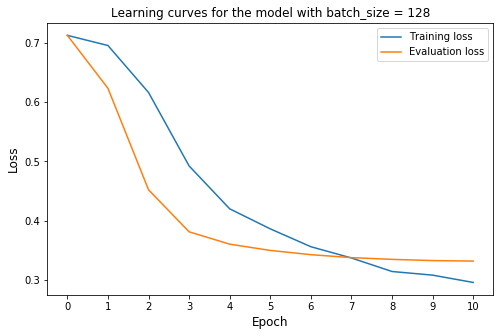

This time we can see the improvement, the validation error seems to constantly decrease, the curve is more smooth. As it turned out this could be the right way to one more time improve the model's predictive abilities.

#### 12. Learning curves for the model with batch_size = 256.
<br>
<div>
<img src="assets/learning_curves_batch256.png" width="500" />
</div>

During the above training trial, we recorded the lowest validation error among all preceding trials that equals around 0.32.

#### 13. Learning curves for the model with min_word_count = 3 and max_seq_len = 0.9.

As the last hyperparameters to tune we will use the min_word_count and max_seq_len.

* min_word_count will be changed to the value of 3 so that the vocabulary will contain all the words which occur at least 3 times in the entire dataset.
* max_seq_len is going to be changed to the values of 0.9, which corresponds to the 0.9 quantile of the distribution of the lengths, that will be the maximum lengths threshold.

<div>
<img src="assets/learning_curves_mwc3_msl09.png" width="500" />
</div>

#### The summary - final set of hyperparameters

Considering all above training trials, we can draw the following conclusions:
- increasing the dropout probability helps in reducing the model's overfitting.
- spatial dropout works better in terms of decreasing the variance problem than the traditional dropout.
- the most improvement in reducing overfitting is due to the reduction of hidden_size.
- using stacked GRU doesn't improve in our case the model's performance.
- reducing the batch_size doesn't significantly affect the model's learning ability what is rather unexpected while increasing the batch_size does improve a bit the model's performance.

The following are the hyperparameters that will be used to finaly train our neural network:
- hidden_size = 8 <br>
- embedding_dim = 200 <br>
- n_layers = 1 <br>
- dropout = 0.5 <br>
- learning_rate = 0.001 <br>
- epochs = 20 <br>
- spatial_dropout = True <br>
- batch_size = 256 <br>
- min_word_count = 3 <br>
- max_seq_len = 0.9 <br>

Below we will use the *tensorboardX* to create the graph of our neural network model that has been depicted at the top of this notebook. You can encounter torch._C.Value issue while using *add.graph()* method, to tackle that I recommend following the *github* thread devoted to this topic:
<br>https://github.com/lanpa/tensorboardX/issues/483<br>
namely, you can try to build tensorboardX from source with:
<br>*git clone https://github.com/lanpa/tensorboardX && cd tensorboardX && python setup.py install*

In [27]:
hidden_size = 4
vocab_size = len(train_iterator.word2index)
embedding_dim = 200
n_layers = 2
output_size = 2
spatial_dropout = True
dropout = 0.5

writer = SummaryWriter('runs/exp-1')

for batch in train_iterator:
    input_seq, _, x_lengths = batch['input_seq'], batch['target'], batch['x_lengths']

with SummaryWriter(comment='Model graph') as w:
    w.add_graph(BiGRU(hidden_size, vocab_size, embedding_dim, output_size, n_layers, dropout,
                      spatial_dropout, bidirectional=True), (input_seq, x_lengths), True)

graph(%self : ClassType<BiGRU>,
      %input_seq : Long(256, 35),
      %lengths.1 : Long(256)):
  %1 : ClassType<Embedding> = prim::GetAttr[name="embedding"](%self)
  %weight.1 : Tensor = prim::GetAttr[name="weight"](%1)
  %5 : ClassType<GRU> = prim::GetAttr[name="gru"](%self)
  %6 : Tensor = prim::GetAttr[name="weight_ih_l0"](%5)
  %7 : Tensor = prim::GetAttr[name="weight_hh_l0"](%5)
  %8 : Tensor = prim::GetAttr[name="bias_ih_l0"](%5)
  %9 : Tensor = prim::GetAttr[name="bias_hh_l0"](%5)
  %10 : Tensor = prim::GetAttr[name="weight_ih_l0_reverse"](%5)
  %11 : Tensor = prim::GetAttr[name="weight_hh_l0_reverse"](%5)
  %12 : Tensor = prim::GetAttr[name="bias_ih_l0_reverse"](%5)
  %13 : Tensor = prim::GetAttr[name="bias_hh_l0_reverse"](%5)
  %14 : Tensor = prim::GetAttr[name="weight_ih_l1"](%5)
  %15 : Tensor = prim::GetAttr[name="weight_hh_l1"](%5)
  %16 : Tensor = prim::GetAttr[name="bias_ih_l1"](%5)
  %17 : Tensor = prim::GetAttr[name="bias_hh_l1"](%5)
  %18 : Tensor = prim::GetAttr[na

### The generalization error

In [28]:
# Import the dataset. Use clean_review and label columns
test_dataset = pd.read_csv('dataset/drugreview_feat_clean/test_feat_clean.csv',
                          usecols=['clean_review', 'rating'])

# Change columns order
test_dataset['label'] = test_dataset.rating >= 5
test_dataset = test_dataset[['clean_review', 'label']]

In [31]:
test_dataset = test_dataset.dropna()
test_dataset.head()

,clean_review,label
2,given sample doctor mg hours lower abdominal g...,False
3,given medication post hysteroscopy suffered se...,True
4,loperamide helpful diarrhea fewer caplets help...,True
10,use claritin d seasonal allergies started taki...,True
15,worked immediate effects noticeable long term,True


In [32]:
test_iterator = BatchIterator(test_dataset, batch_size=256, vocab_created=False, vocab=None, target_col=None,
                              word2index=train_iterator.word2index, sos_token='<SOS>', eos_token='<EOS>',
                              unk_token='<UNK>', pad_token='<PAD>', min_word_count=3, max_vocab_size=None,
                              max_seq_len=0.9, use_pretrained_vectors=False, glove_path='glove/',
                              glove_name='glove.6B.100d.txt', weights_file_name='glove/weights.npy')

Trimmed vocabulary using as minimum count threashold: count = 3.00
3069/8377 tokens has been retained
Trimmed input strings vocabulary
Trimmed input sequences lengths to the length of: 54
Mapped words to indices
Batches created


In [33]:
_, test_avg_loss, test_accuracy, test_conf_matrix = model.evaluate_model(test_iterator)

Evaluation:   0%|          | 0/9 [00:00<?, ?it/s]

In [34]:
print('Test accuracy: {:.3f}. Test error: {:.3f}'.format(test_accuracy, test_avg_loss))

Test accuracy: 0.808. Test error: 0.435


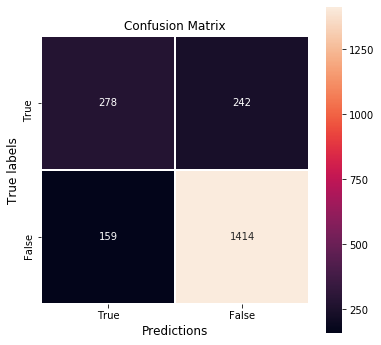

In [35]:
# Confusion matrix
plt.figure(figsize=(6,6))
ax = sns.heatmap(test_conf_matrix, fmt='d', annot=True, linewidths=1, square=True)
ax.set_xlabel('Predictions', size=12)
ax.set_ylabel('True labels', size=12) 
ax.set_title('Confusion Matrix', size=12); 
ax.xaxis.set_ticklabels(['True', 'False'])
ax.yaxis.set_ticklabels(['True', 'False'])
ax.set_ylim(2,0)
plt.show()

The generalization accuracy of the biGRU model equals 0.808. As we can see on the above plot of the confusion matrix the both, positive and negative classes were similarly numerous, and the prediction mistakes amount (TN, FP) is also very similar, so model learned both classes in the same detail. 